In [63]:
!pip install tqdm
import csv
import os
import datetime
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import warnings

warnings.simplefilter("ignore", UserWarning)

ision', 3: 'Fan', 4: 'Fridge', 5: 'Laptop computer', 6: 'Electric heating element', 7: 'Oven', 8: 'Unknown', 9: 'Washing machine', 10: 'Microwave', 11: 'Toaster', 12: 'Sockets', 13: 'Cooker'}
device_dict = {3: 'kettle', 4: 'microwave', 5: 'fridge', 6: 'dishwasher', 7: 'washing machine', 8: 'Unknown', 9: 'Unknown', 10: 'Unknown', 11: 'Unknown', 12: 'Unknown', 13: 'Unknown'}
device_list = list(device_dict.values())

In [64]:
def process_file(filename, device_dict):
    # Initialize power_dict with keys for each device name (lowercase)
    power_dict = {key.lower(): {} for key in device_dict.values()}
    samples = []

    # Open file and read through it, adding data to power_dict
    with open(filename, 'r') as file:
        csvreader = csv.reader(file)
        lines = [line for line in csvreader]

        current_day = None
        for row in tqdm(lines[1:], smoothing=0):
            # Parse date and time from first column
            date_time = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S%z')

            # Check if the current row belongs to the current day
            if current_day is None:
                current_day = date_time.date()
            elif date_time.date() != current_day:
                # If the current row is for a different day, process the current day's data
                processed_data = formatting(power_dict)
                samples.append(processed_data)

                # Clear power_dict for the next day's data
                power_dict = {key.lower(): {} for key in device_dict.values()}
                current_day = date_time.date()

            # Add data to power_dict
            count = 0
            for value in row[2:]:
                if device_list[count] in power_dict:
                    power_dict[device_list[count]][date_time] = float(value)
                    count += 1

    return samples



In [65]:
def formatting(power_dict):
    processed_data = {}
    for appliance in power_dict:
        # Convert the data in the inner dictionary to a dataframe
        power_dict[appliance] = pd.DataFrame.from_dict(power_dict[appliance], 
                                                        orient='index', 
                                                        columns=[appliance])
        
        power_dict[appliance].index = pd.to_datetime(power_dict[appliance].index,utc=True)

        # Resample the dataframe to 7 seconds intervals and backfill the missing values
        power_dict[appliance] = power_dict[appliance].resample('7s').ffill(limit=1).fillna(0)
        # Convert the index to period of seconds
        power_dict[appliance].index = power_dict[appliance].index.to_period('s')

        #if len(sample) < 2 or not np.any(sample > 20):
            #continue

        processed_data[appliance] = power_dict[appliance]
    return processed_data

In [66]:
path = 'new_datasets/LERTA'
files = os.listdir(path)
samples=process_file('new_datasets/LERTA/CLEAN_Lerta_House3.csv', device_dict)
keys=device_list
processed_data = {}
for key in keys:
    values = []
    for sample in samples:
        if key in sample:
            values.append(sample[key])
    processed_data[key] = values

#processed_data = {key: [sample[key] for sample in samples] for key in keys}

<_io.TextIOWrapper name='new_datasets/LERTA/CLEAN_Lerta_House3.csv' mode='r' encoding='UTF-8'>


100%|██████████| 7319442/7319442 [02:20<00:00, 52234.30it/s]


<class 'list'>


kettle 365
microwave 365
fridge 365
dishwasher 365
washing machine 365
kettle 365
microwave 365
fridge 365
dishwasher 365
washing machine 365
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


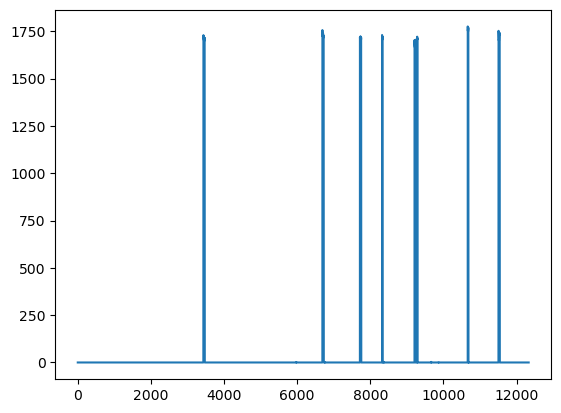

In [88]:
#print(processed_data['kettle'])
new_dict = {}
for device, data in processed_data.items():
        processed_data[device] = data[:365]
for n,m in processed_data.items():
    print(n,len(m))
for n, m in processed_data.items():
    items = [item for item in m if len(item) > 12300]
    if items:
        new_dict[n] = items
for n,m in new_dict.items():
    print(n,len(m))

processed_data=new_dict.copy()


In [89]:
import pickle
# Save processed data to a pickle file
with open('letra_processed.pkl', 'wb') as handle:
    pickle.dump(processed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)